In [1]:
import os
import string
import numpy as np
from math import log
from scipy import sparse
from sklearn import datasets
from scipy import linalg as la
from collections import Counter
from matplotlib import pyplot as plt
from scipy.sparse import linalg as spla

%matplotlib inline

In [2]:
plt.rcParams["figure.dpi"] = 300

### PCA on the iris dataset, keeping the first two principal components:

In [104]:
iris = datasets.load_iris()
X = iris.data
Y = X - X.mean(axis=0)
U,S,VT = la.svd(Y, full_matrices=False)
S**2/(S**2).sum() # variance percentages

array([ 0.92461621,  0.05301557,  0.01718514,  0.00518309])

In [105]:
def projection(U,S,k):
    '''Calculates projection of the i-th observation onto the 
        orthonormal set of the first k principal components
    Parameters:
        U - U matrix from SVD
        S - ndarray, singular values
        k - int, number of principal components to keep
    Returns:
        projection'''
    return U[:,:k].dot(S[:k] * np.eye(k))

In [106]:
keep = 2 # number of components to keep
Yhat = projection(U,S,keep)

(-4, 4)

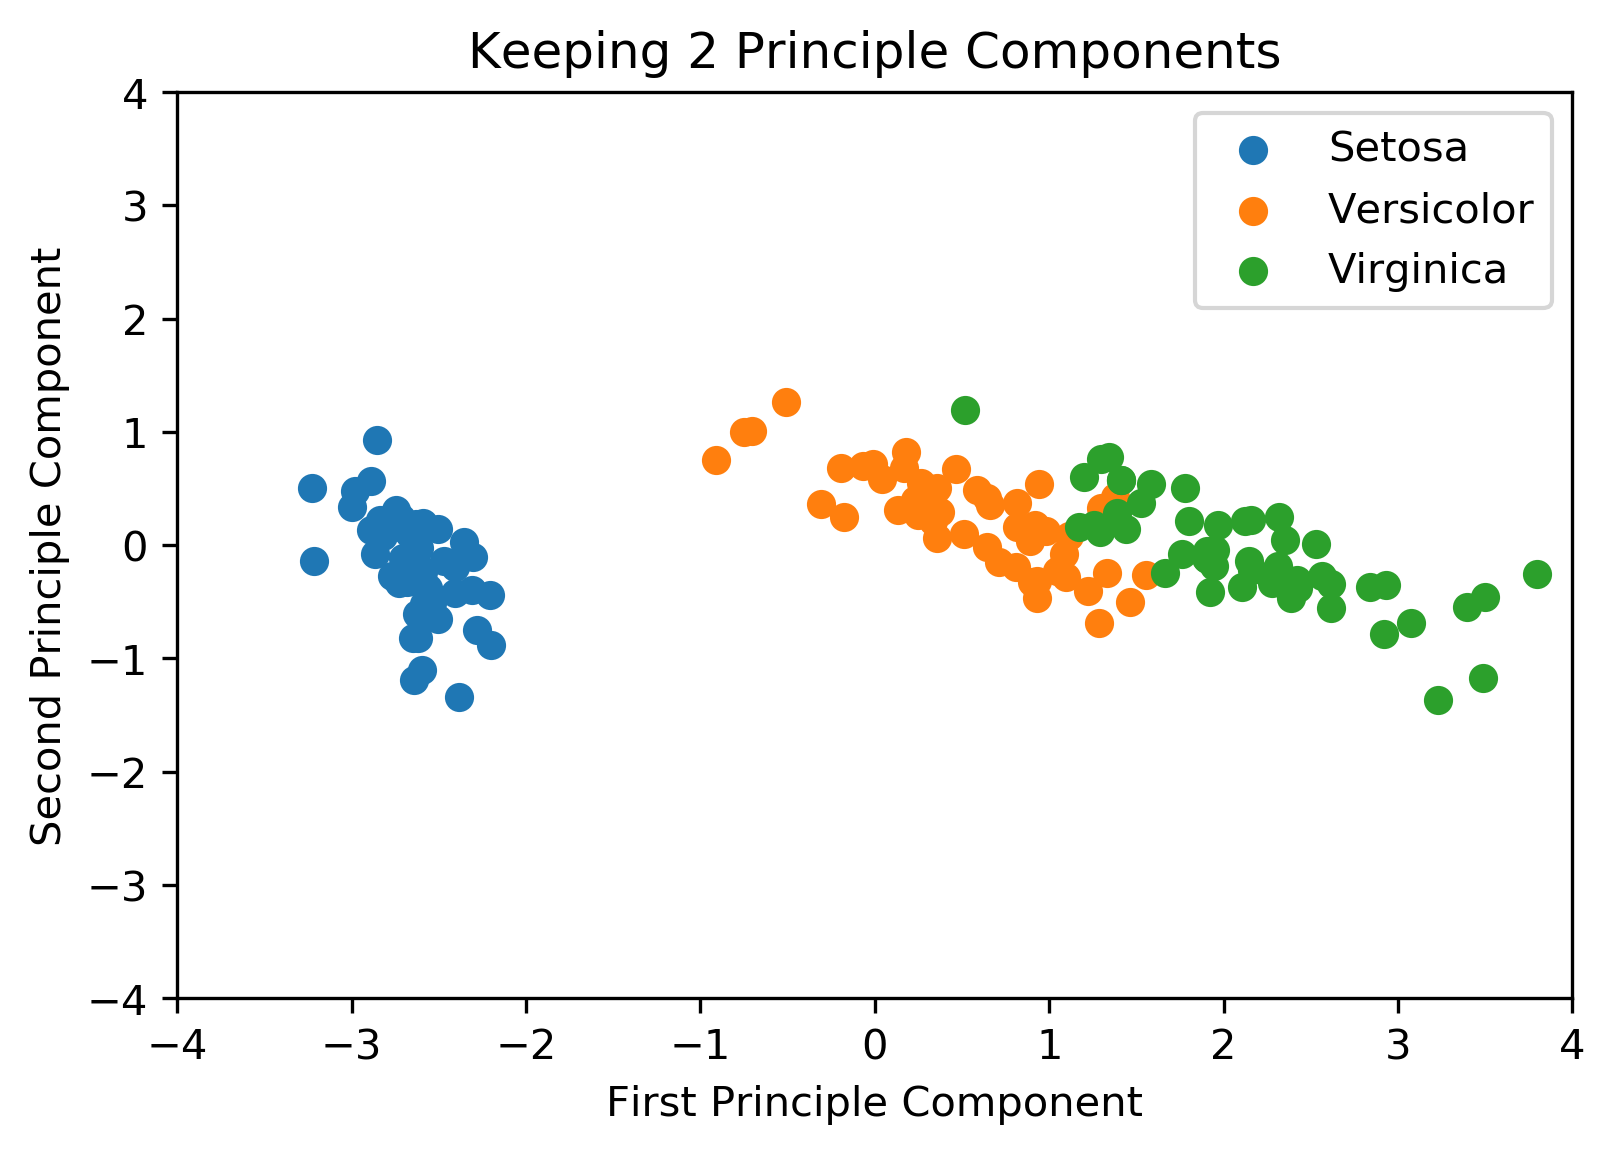

In [107]:
# Plot
plt.scatter(Yhat[iris.target==0][:,0],Yhat[iris.target==0][:,1], label='Setosa')
plt.scatter(Yhat[iris.target==1][:,0],Yhat[iris.target==1][:,1], label='Versicolor')
plt.scatter(Yhat[iris.target==2][:,0],Yhat[iris.target==2][:,1], label='Virginica')
plt.legend(loc='best')
plt.title('Keeping 2 Principle Components')
plt.xlabel('First Principle Component')
plt.ylabel('Second Principle Component')
plt.ylim(-4,4)
plt.xlim(-4,4)

Using the techniques of LSI, applied to the word count matrix $X$, and keeping the first 7 principal components, found the most similar and least similar speeches to both Bill Clinton's 1993 speech and to Ronald Reagan's 1984 speech.

In [53]:
# Get list of filepaths to each text file in the folder.
folder = "./Addresses/"
paths = [folder+p for p in os.listdir(folder) if p[-4:]==".txt"]

# Helper function to get list of words in a string.
def extractWords(text):
    ignore = string.punctuation + string.digits
    cleaned = "".join([t for t in text.strip() if t not in ignore])
    return cleaned.lower().split()

# Initialize vocab set, then read each file and add to the vocab set.
vocab = set()
for p in paths:
    with open(p, 'r') as infile:
        for line in infile:
            vocab.update(extractWords(line))

In [54]:
# load stopwords
with open("stopwords.txt", 'r') as f:
    stops = set([w.strip().lower() for w in f.readlines()])

# remove stopwords from vocabulary, create ordering
vocab = {w:i for i, w in enumerate(vocab.difference(stops))}

In [91]:
counts = []      # holds the entries of X
doc_index = []   # holds the row index of X
word_index = []  # holds the column index of X

# Iterate through the documents.
for doc, p in enumerate(paths):
    with open(p, 'r') as f:
        # Create the word counter.
        ctr = Counter()
        for line in f:
            ctr.update(extractWords(line))
        # Iterate through the word counter, store counts.
        for word, count in ctr.items():
            if word in vocab:
                word_index.append(vocab[word])
                counts.append(count)
                doc_index.append(doc)

# Create sparse matrix holding these word counts.
X = sparse.csr_matrix((counts, [doc_index, word_index]),
                       shape=(len(paths), len(vocab)), dtype=np.float)

In [92]:
def index_of_speech(last_name,year,paths):
    '''Find the index of a given speech in paths
    Parameters:
        last_name - string, last name of person who gave the speech
        year - int year the speech was given
        paths - list of file paths to txt file of speeches
    Returns:
        int - index of speech
    '''
    return paths.index(f'./Addresses/{year}-{last_name}.txt')

In [93]:
def find_similarity(index, Xhat):
    '''Find most/least similar speeches to given speech
    Parameters:
        index - int, index of speech to compare
        Xhat - Matrix, corpus of documents
    Returns:
        most_similar - index of most similar speech
        least_similar - index of least similar speech
    '''
    # Row corresponding to speech i
    speech_i = Xhat[index,:]
    
    # Dot speech_i with Xhat.T to get inner product of speech_i with all rows
    similarity = speech_i.dot(Xhat.T) / (la.norm(speech_i)*la.norm(Xhat,axis=1))
    
    # Get index of max and min (remember max is the same as speech_i)
    similarity[np.argmax(similarity)] = np.mean(similarity)
    most_similar = np.argmax(similarity)
    least_similar = np.argmin(similarity)
    
    return most_similar, least_similar

In [94]:
def print_similarity(most, least, paths):
    '''Prints the most/least similar speeches
    Parameters:
        most - int, index of most similar speech
        least - int, index of least similar speech
        paths - list, paths to each speech
    '''
    print(f"Most similar speech: {paths[most][12:-4]} \nLeast similar speech: {paths[least][12:-4]}")

In [95]:
keep = 7
U,S,VT = spla.svds(X,k=keep)
Xhat = projection(U,S,keep)

###  Compare Bill Clinton's 1993 speech

In [96]:
index_clinton = index_of_speech('Clinton', 1993, paths)
most_similar, least_similar = find_similarity(index_clinton, Xhat)
print_similarity(most_similar, least_similar, paths)

Most similar speech: 2010-Obama 
Least similar speech: 1951-Truman


###  Compare Ronald Reagan's 1984 speech

In [97]:
index_reagan = index_of_speech('Reagan', 1984, paths)
most_similar, least_similar = find_similarity(index_reagan, Xhat)
print_similarity(most_similar, least_similar, paths)

Most similar speech: 1988-Reagan 
Least similar speech: 1946-Truman


Repeat using the matrix $A$ (sparse matrix holding these globally weighted word counts).

In [98]:
t = np.zeros(len(vocab))
counts = []
doc_index = []
word_index = []

# get doc-term counts and global term counts
for doc, path in enumerate(paths):
    with open(path, 'r') as f:
        # create the word counter
        ctr = Counter()
        for line in f:
            words = extractWords(line)
            ctr.update(words)
        # iterate through the word counter, store counts
        for word, count in ctr.items():
            if word in vocab:
                word_ind = vocab[word]
                word_index.append(word_ind)
                counts.append(count)
                doc_index.append(doc)
                t[word_ind] += count

# Get global weights.
g = np.ones(len(vocab))
logM = log(len(paths))
for count, word in zip(counts, word_index):
    p = count/float(t[word])
    g[word] += p*log(p+1)/logM

# Get globally weighted counts.
gwcounts = []
for count, word in zip(counts, word_index):
    gwcounts.append(g[word]*log(count+1))

# Create sparse matrix holding these globally weighted word counts
A = sparse.csr_matrix((gwcounts, [doc_index,word_index]),
                      shape=(len(paths), len(vocab)), dtype=np.float)


In [99]:
U,S,VT = spla.svds(A,k=keep)
Ahat = projection(U,S,keep)

###  Compare Bill Clinton's 1993 speech

In [100]:
most_similar, least_similar = find_similarity(index_clinton, Ahat)
print_similarity(most_similar, least_similar, paths)

Most similar speech: 1992-Bush 
Least similar speech: 1946-Truman


###  Compare Ronald Reagan's 1984 speech

In [101]:
most_similar, least_similar = find_similarity(index_reagan, Ahat)
print_similarity(most_similar, least_similar, paths)

Most similar speech: 1985-Reagan 
Least similar speech: 1946-Truman
